# <center> <b>  SUPERMARKET WEEKLY SALES REPORT

<span style="color: #0071ce; font-family: Babas; font-size: 2.1em;"> <b>Content</b>
1. Import data.
2. EDA.
3. Features Selection.
4. Model development.
5. Conclusion.
6. Recommendation and Benefits.

<span style="color: #0071ce; font-family: Babas; font-size: 2.1em;"> Overview
    
This is historical data including sales from 2010-02-05 to 2012-11-01 in the file "Walmart_Store_sales.csv". About the dataset "Walmart Dataset (Retail)":

1. Store - The Store ID number.
2. Date - The week of sales.
3. Weekly_Sales - Sales record in the week of given store.
4. Holiday_Flag - Indicate whether the week has Public Holiday or not. (1 – Holiday week, 0 – Non-holiday week)
5. Temperature - Average temperature of the week.
6. Fuel_Price - Average fuel price of the week in the region.
7. CPI – Prevailing Consumer Price Index.
8. Unemployment - Prevailing Unemployment Rate.

Holiday Events:
- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13    

<b><u>Main task</b></u>: Explore the dataset and create models to predict the sales (Weekly_Sales).

### Overall comments:

The dataset describes the activities of 45 stores in 3 years 2010, 2011 and 2012 with a total number of sales revenue of 6428 times. In general, the features are distributed relatively evenly, the dataset does not appear missing values.

This is a dataset with 93% data recorded during weekdays and approximately 7% recorded during holidays

The majority of holidays will have higher average sales than regular days. The total weekly sales of stores fluctuates unevenly, with some stores having sales about 6-7 times higher than others.

# Library

pip install lightgbm

pip install xgboost

pip install pmdarima

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import datetime as dt
warnings.filterwarnings("ignore")
from datetime import datetime
%matplotlib inline

# Sklearn
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn import ensemble, metrics, model_selection, linear_model
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error,classification_report
from lightgbm import LGBMRegressor,log_evaluation
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import ensemble, metrics, model_selection, linear_model
from sklearn.linear_model import Ridge,LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

In [2]:
palette = ["#0071CE","#FFC220",  "#76c043", "#78b9e7", "#367c2b", "#007dc6",
           "#367c2b", "#76c043"]
sns.set_style("whitegrid")
sns.set_palette(palette)

## 1. Import data.

In [3]:
# Load CSV file as dataframe.
df = pd.read_csv('./data/Walmart_Store_sales.csv')
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


## 2. EDA

### 2.1. Overall.
- Target feature is Weekly_Sales
- The date format in the dataset is adjusted
- Holiday_flag is a feature containing a dummy variable (shows 1 if it's one of the 4 holidays, shows 0 if it's not a holiday)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [5]:
df.isnull().sum().to_frame().T

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,0,0,0,0,0,0,0,0


#### <u> Comment</u>: 
There are no null values.

In [6]:
print('No Holiday', round(df['Holiday_Flag'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Holiday', round(df['Holiday_Flag'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Holiday 93.01 % of the dataset
Holiday 6.99 % of the dataset


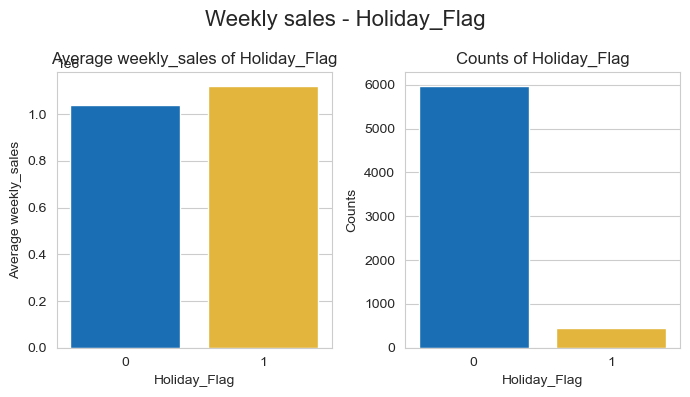

In [7]:
holiday_sale = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
holiday_count = df.groupby('Holiday_Flag')['Weekly_Sales'].count()

fig, axes = plt.subplots(1,2, figsize=(7,4), dpi=100)

ax1 = sns.barplot(x=holiday_sale.index, y=holiday_sale.values, ax=axes[0])
ax1.set_title('Average weekly_sales of Holiday_Flag')
ax1.set_xlabel('Holiday_Flag')
ax1.set_ylabel('Average weekly_sales')

ax2 = sns.barplot(x=holiday_count.index,y=holiday_count.values, ax=axes[1])
ax2.set_title('Counts of Holiday_Flag')
ax2.set_xlabel('Holiday_Flag')
ax2.set_ylabel('Counts')

plt.suptitle('Weekly sales - Holiday_Flag', fontsize = 16)
fig.tight_layout()
plt.show()

#### <u> Comment</u>: 
This is a dataset with 93% data recorded during weekdays and approximately 7% recorded during holidays.

In [8]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [9]:
df.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000


In [10]:
# Change the Date column to the correct datatime type.
df['Date']  =  pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [11]:
# Create Month, Week, Day columns
df['Year'], df['Month'] = df['Date'].dt.year, df['Date'].dt.month
df['Week'] = df['Date'].dt.week
df['Day'] = df['Date'].dt.day

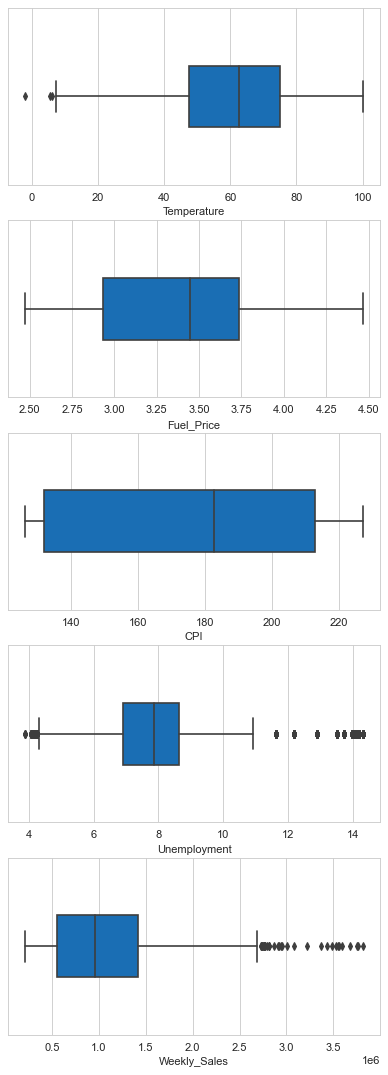

In [12]:
# Display data distribution of Temperature, Fuel Price, CPI, and Unemployment columns.
fig, axis = plt.subplots(5, figsize=(6,17), dpi=80)
x = df[['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales']]

for i, column in enumerate(x):
    sns.boxplot(df[column], ax=axis[i], width=0.35)

import warnings
warnings.filterwarnings('ignore')

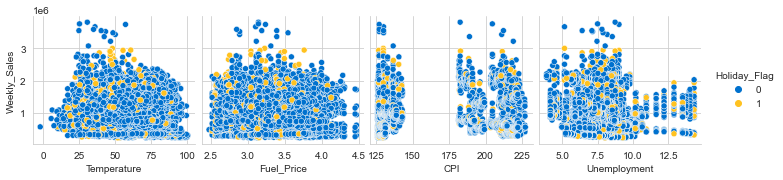

In [13]:
pp = sns.pairplot(data=df,
                  y_vars=['Weekly_Sales'],
                  x_vars=['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
                  hue='Holiday_Flag')

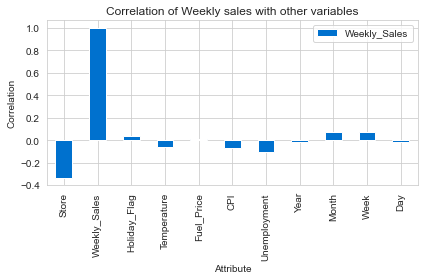

In [14]:
#Relationship of Weekly Sales among Temperature, FuelPrice, CPI, Holiday and Store
df_corr = df.corr()
ax=df_corr[['Weekly_Sales']].plot(kind='bar')
plt.xlabel('Attribute')
plt.ylabel('Correlation')
plt.title('Correlation of Weekly sales with other variables')
plt.tight_layout()
plt.show()

#### <u> Comment</u>: 
Features Store, Temperature, Unemployment, Fuel_Price, CPI, Holiday_Flag, Week, Month, Quarter, Year have a very weak correlation with Weekly_Sales (none is above 0.5)

### 2.2. Sales Analysis.

Text(0.5, 1.0, 'Yearly Sales')

<Figure size 1600x480 with 0 Axes>

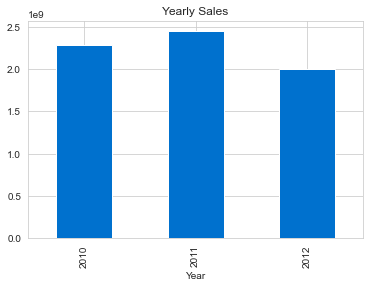

In [15]:
plt.figure(figsize=(20,6), dpi=80)
df.groupby('Year')[['Weekly_Sales']].sum().plot(kind='bar', legend=False, color = palette)
plt.title('Yearly Sales')

#### <u> Comment</u>: 
The supermarket's annual revenue did not fluctuate too much over the years, the highest in 2011 and the lowest in 2012.

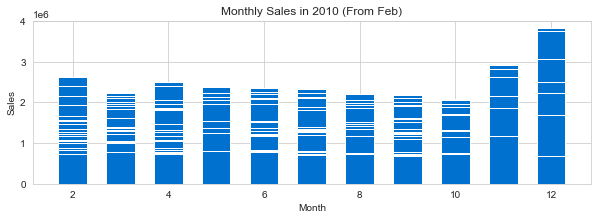

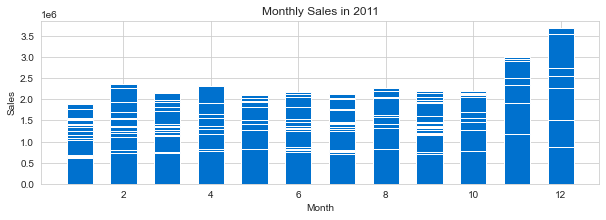

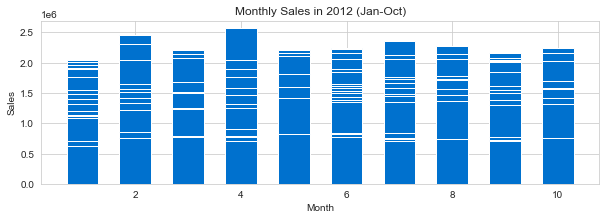

In [16]:
# fist line: Sales of the week in 2010 by month.
plt.figure(figsize=(10,3))
df_2010 = df[df["Year"] ==2010]
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales in 2010 (From Feb)')
plt.bar(df_2010['Month'],df_2010['Weekly_Sales'], width=0.6)
 
# second line: Sales of the week in 2011 by month.
df_2011 = df[df["Year"]==2011]
plt.figure(figsize = (10, 3))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales in 2011')
plt.bar(df_2011['Month'],df_2011['Weekly_Sales'], width=0.6)

# third line: Sales of the week in 2012 by month.
df_2012 = df[df["Year"]==2012]
plt.figure(figsize = (10, 3))
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales in 2012 (Jan-Oct)')
plt.bar(df_2012['Month'],df_2012['Weekly_Sales'], width=0.6)

# Show the graph
plt.show()

#### <u> Comment</u>: 
- 2010 sales have a big difference between December compared to the rest of the year, with revenue in December recorded at about 380 million.
- December 2011 continued to record the largest revenue (about 400 million) and there was a very clear difference compared to the remaining months.
- In 2012, the difference between months is not too large, April recorded the largest total revenue (about 300 million).

### 2.3. Stores' Sales Analysis.

<AxesSubplot:title={'center':'Top 5 Stores by Sales'}, xlabel='Store', ylabel='Weekly_Sales'>

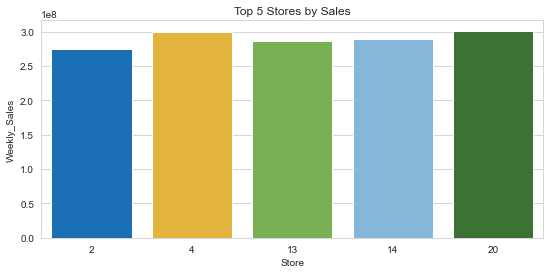

In [17]:
df_store = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
df_top5 = df_store.head(5).to_frame().reset_index()
df_top5['Store'].astype('string')
plt.figure(figsize=(9,4))
plt.xlabel('Store')
plt.ylabel('Sales')
plt.title('Top 5 Stores by Sales')
sns.barplot(data = df_top5, x = df_top5['Store'],y = df_top5['Weekly_Sales'], palette = palette)

#### <u> Comment</u>:
Store No. 20, 4, 14, 13, and 2 have the largest cumulative total sales.

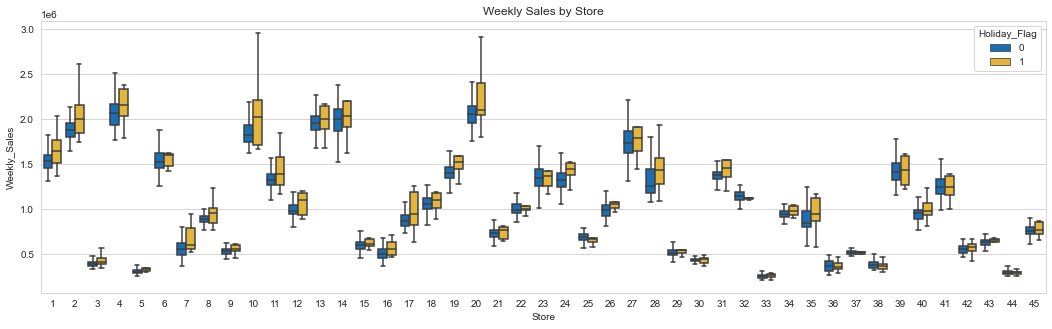

(Text(0.5, 1.0, 'Weekly Sales by Store'), None)

In [18]:
def boxplot (df, var_label, var_y, var_class, outliers=True):
    plt.figure(figsize = (18,5))
    if var_class!="":
        fig = sns.boxplot(x = var_class
                          ,y =  var_y
                          ,data = df[[var_class, var_y, var_label]]
                          ,showfliers = outliers
                          ,hue = var_label                     )
    else:
        fig = sns.boxplot(x = var_label ,y = var_y
                          ,data = df[[var_label,var_y]]
                          ,showfliers = outliers
                     )
    return plt.title('Weekly Sales by Store'),plt.show()

boxplot(df,"Holiday_Flag","Weekly_Sales","Store",False)


#### <u> Comment</u>: 
The total weekly sales of stores fluctuates unevenly, some stores have about 6-7 times higher sales than others, the frequency of this is not much and the reason may come from a few stores that do not have the right way to market to customers or from the geographical characteristics, the size of the store, the local culture.

In [19]:
# Store with highest coefficient value 
coefficient_all = ((df.groupby('Store')['Weekly_Sales'].std())/(df.groupby('Store')['Weekly_Sales'].mean()))*100
print("Store with highest coefficient value is {} ".format(coefficient_all.idxmax()))

Store with highest coefficient value is 35 


<AxesSubplot:title={'center':'Weekly Sales by Store'}, xlabel='Weekly_Sales', ylabel='Density'>

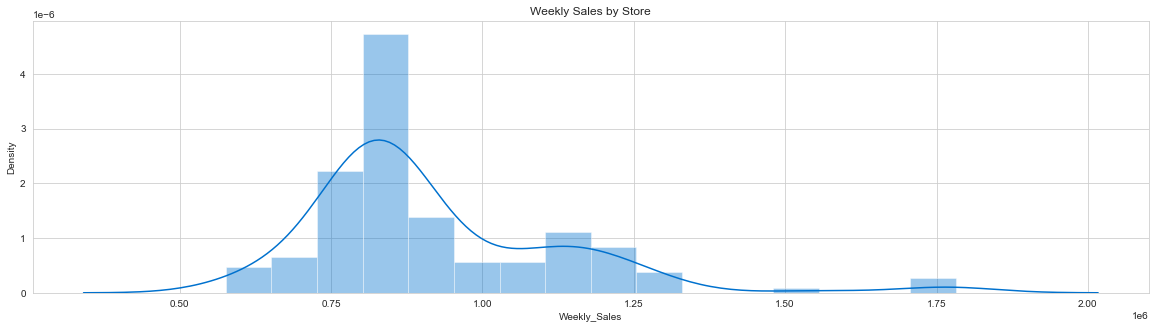

In [20]:
stores = df.groupby('Store')
store_35 = stores.get_group(35)
plt.figure(figsize=(20,5))
plt.title('Weekly Sales by Store')
sns.distplot(store_35.Weekly_Sales)

### 2.4. Holiday and Non_Holiday Sales Analysis:

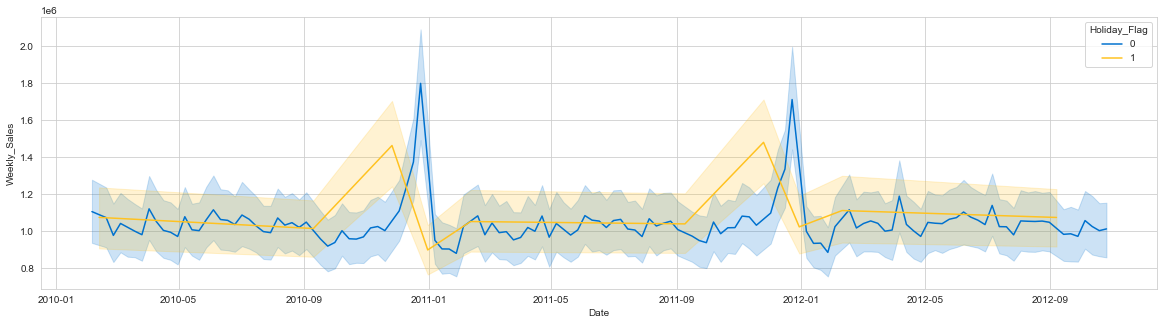

In [21]:
# so sánh sales holiday vs sales non-holiday overtime
plt.figure(figsize=(20,5))
sns.lineplot(data=df, x="Date", y="Weekly_Sales", hue = "Holiday_Flag")
plt.show()

#### <u> Comment</u>:  
When looking at the chart and comparing the performance of holiday sales versus non-holidays, it can be seen that on average, holidays have a higher volume of sales than weekdays.

In [22]:
cont = df['Holiday_Flag'] == 1
df_holiday = df.loc[cont]
df_noholiday = df.loc[~cont]

# Avg sales holiday vs Avg sales non-holiday

print("Avg sales holiday:",df_holiday["Weekly_Sales"].mean())
print("Avg sales non-holiday:",df_noholiday["Weekly_Sales"].mean())

Avg sales holiday: 1122887.8923555554
Avg sales non-holiday: 1041256.3802088564


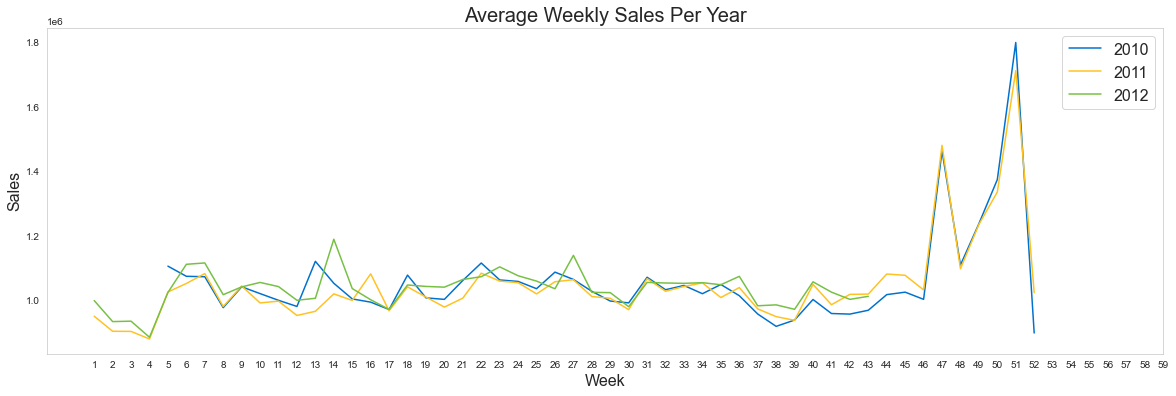

In [23]:
# Compare sales by week among years
weekly_sales_2010 = df[df['Year']==2010]['Weekly_Sales'].groupby(df['Week']).mean()
weekly_sales_2011 = df[df['Year']==2011]['Weekly_Sales'].groupby(df['Week']).mean()
weekly_sales_2012 = df[df['Year']==2012]['Weekly_Sales'].groupby(df['Week']).mean()

plt.figure(figsize=(20,6))

sns.lineplot(weekly_sales_2010.index, weekly_sales_2010.values)
sns.lineplot(weekly_sales_2011.index, weekly_sales_2011.values)
sns.lineplot(weekly_sales_2012.index, weekly_sales_2012.values)

plt.grid()
plt.xticks(np.arange(1,60, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales Per Year', fontsize=20)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)

plt.show()

### <u> Comment </u>: 
- In 2010, 2011, the weeks of thanksgiving and the first week before Christmas saw a sudden increase in revenue
- As can be seen, the sales trend from year to year is similar and tends to spike from week 46 to 52 - the last weeks of the year focus on many holidays. So it can be seen that holidays have a clear effect on the sales of the week

In [24]:
Avg_H_Sales = df_holiday.groupby(["Year", "Month"])[["Weekly_Sales"]].mean()
Avg_NH_Sales = df_noholiday.groupby(["Year", "Month"])[["Weekly_Sales"]].mean()
Avg_H_Sales["Weekly_Sales_Holiday"] = Avg_H_Sales["Weekly_Sales"]

Avg_H_Sales_Y = Avg_H_Sales.drop(["Weekly_Sales"], axis = 1).style.format("{:.1f}")
Avg_H_Sales_Y

In [25]:
Avg_NH_Sales_Y = Avg_NH_Sales.style.format("{:.1f}")
Avg_NH_Sales_Y

### <u> Comment</u>:  
It can be seen that in the months with holidays, the average sales of the holiday week is much higher than the average of the non-holiday week, specifically when looking at February 2010, November 2010, Super_Bowl and Thanksgiving are likely to attract more demand.

#### Compare performance among holidays

In [26]:
# Create holiday ranges
Super_Bowl = ['2010-02-12', '2011-02-11', '2012-02-10']
Labour_Day =  ['2010-09-10', '2011-09-09', '2012-09-07']
Thanksgiving =  ['2010-11-26', '2011-11-25', '23-11-2012']
Christmas = ['2010-12-31', '2011-12-30', '28-12-2012']

In [27]:
df["Super_Bowl"] = np.where(df.Date.astype('string').isin(Super_Bowl), 1, 0) 
df["Labour_Day"] = np.where(df.Date.astype('string').isin(Labour_Day), 1, 0) 
df["Thanksgiving"] = np.where(df.Date.astype('string').isin(Thanksgiving), 1, 0) 
df["Christmas"] = np.where(df.Date.astype('string').isin(Christmas), 1, 0) 

In [28]:
# Contribution of each holiday to total holiday revenue
data_pie = [] 
data_pie.append(df.loc[df["Super_Bowl"] == 1]["Weekly_Sales"].sum())
data_pie.append(df.loc[df["Labour_Day"] == 1]["Weekly_Sales"].sum()) 
data_pie.append(df.loc[df["Thanksgiving"] == 1]["Weekly_Sales"].sum()) 
data_pie.append(df.loc[df["Christmas"] == 1]["Weekly_Sales"].sum())

labels = ["Super_Bowl", "Labour_Day", "Thanksgiving", "Christmas"]

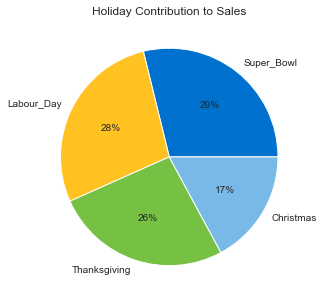

In [29]:
plt.figure(figsize=(5,5))
colors = sns.color_palette('bright')[0:4]
plt.title('Holiday Contribution to Sales')
plt.pie(data_pie, labels = labels, autopct='%.0f%%')

plt.show()

In [30]:
# Compare average sales for each week

Super_Bowl_Sales = df.loc[df["Super_Bowl"] == 1]["Weekly_Sales"].mean()
Labour_Day_Sales = df.loc[df["Labour_Day"] == 1]["Weekly_Sales"].mean()
Thanksgiving_Sales = df.loc[df["Thanksgiving"] == 1]["Weekly_Sales"].mean()
Christmas_Sales = df.loc[df["Christmas"] == 1]["Weekly_Sales"].mean()


Mean_Sales = {'Super_Bowl_Sales' : Super_Bowl_Sales,
              'Labour_Day_Sales': Labour_Day_Sales,
              'Thanksgiving_Sales':Thanksgiving_Sales,
              'Christmas_Sales': Christmas_Sales}

pd.DataFrame(Mean_Sales, index = range(len(Mean_Sales)))[:1].style.format("{:.1f}")

,Super_Bowl_Sales,Labour_Day_Sales,Thanksgiving_Sales,Christmas_Sales
0,1079128.0,1042427.3,1471273.4,960833.1


In [31]:
# Compare median sales for each week (avoiding outliers' impacts)


Super_Bowl_Sales2 = df.loc[df["Super_Bowl"] == 1]["Weekly_Sales"].median()
Labour_Day_Sales2 = df.loc[df["Labour_Day"] == 1]["Weekly_Sales"].median()
Thanksgiving_Sales2 = df.loc[df["Thanksgiving"] == 1]["Weekly_Sales"].median()
Christmas_Sales2 = df.loc[df["Christmas"] == 1]["Weekly_Sales"].median()


Median_Sales = {'Super_Bowl_Sales' : Super_Bowl_Sales2,
              'Labour_Day_Sales': Labour_Day_Sales2,
              'Thanksgiving_Sales':Thanksgiving_Sales2,
              'Christmas_Sales': Christmas_Sales2}

pd.DataFrame(Median_Sales , index = range(len(Median_Sales )))[:1].style.format("{:.1f}")

,Super_Bowl_Sales,Labour_Day_Sales,Thanksgiving_Sales,Christmas_Sales
0,1015654.6,976415.6,1327536.2,889822.0


In [32]:
print(
    df.loc[df["Super_Bowl"] == 1].shape,
    df.loc[df["Labour_Day"] == 1].shape,
    df.loc[df["Thanksgiving"] == 1].shape,
    df.loc[df["Christmas"] == 1].shape
)

(135, 16) (135, 16) (90, 16) (90, 16)


In [33]:
# Revenue variation coefficient of each holiday
Super_Bowl_Sales = df.loc[df["Super_Bowl"] == 1]["Weekly_Sales"].std()/df.loc[df["Super_Bowl"] == 1]["Weekly_Sales"].mean()*100
Labour_Day_Sales = df.loc[df["Labour_Day"] == 1]["Weekly_Sales"].std()/df.loc[df["Labour_Day"] == 1]["Weekly_Sales"].mean()*100
Thanksgiving_Sales = df.loc[df["Thanksgiving"] == 1]["Weekly_Sales"].std()/df.loc[df["Thanksgiving"] == 1]["Weekly_Sales"].mean()*100
Christmas_Sales = df.loc[df["Christmas"] == 1]["Weekly_Sales"].std()/df.loc[df["Christmas"] == 1]["Weekly_Sales"].mean()*100

coefficient_Sales = {'Super_Bowl_Sales' : Super_Bowl_Sales,
              'Labour_Day_Sales': Labour_Day_Sales,
              'Thanksgiving_Sales':Thanksgiving_Sales,
              'Christmas_Sales': Christmas_Sales}

pd.DataFrame(coefficient_Sales , index = range(len(Mean_Sales )))[:1]

,Super_Bowl_Sales,Labour_Day_Sales,Thanksgiving_Sales,Christmas_Sales
0,53.464053,51.600173,54.187582,52.374068


#### <u> Comment</u>:  
- It can be seen that, although the total revenue from Super_bowl is the highest with 29%, the average revenue is far behind that of Thanksgiving.
- Considering that the number of Super_Bowl weeks is higher than Thanksgiving, so the total revenue is higher is reasonable.
- Out of 4 holidays, Thanksgiving is the holiday that customers spend the most.

## 3. Features Selection.

<AxesSubplot:>

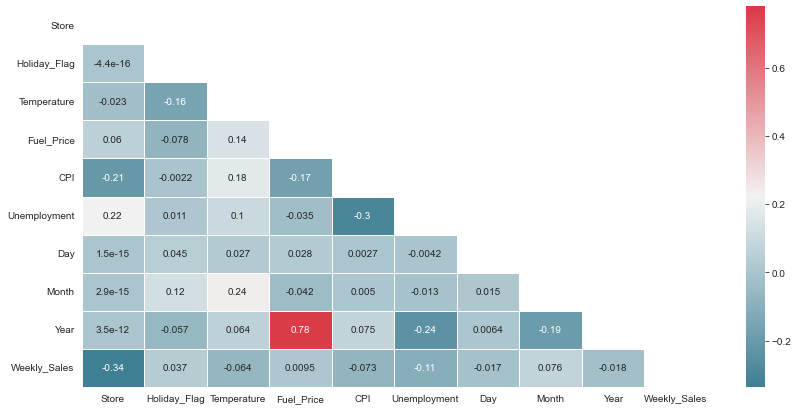

In [34]:
fig, ax = plt.subplots(figsize=(14, 7))
corr = df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Day', 'Month', 'Year','Weekly_Sales']].corr()
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot = True, linewidth=.8, cmap=cmap, mask=mask)

#### <u> Comment</u>: 
Year has a high correlation with Fuel Price (0.78)

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_check = df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Day', 'Month', 'Year']]

vif_results = pd.DataFrame()
vif_results['Feature'] = vif_check.columns

vif_results['VIF'] = [variance_inflation_factor(vif_check.values, i) for i in range(len(vif_check.columns))]
vif_results.sort_values(by = 'VIF', ascending=False)
# cond = vif_results['VIF'] <= 10
# vif_results.loc[cond]

,Feature,VIF
8,Year,142.414061
3,Fuel_Price,60.107994
4,CPI,25.049556
5,Unemployment,22.878344
2,Temperature,14.521910
7,Month,5.480125
0,Store,4.468823
6,Day,4.223481
1,Holiday_Flag,1.140865


#### <u> Comment</u>:  
- Features: 'Holiday Flag', 'Day', 'Store', 'Month' will be used for Models that are seriously affected by multicollinearity, which has VIF values less then 10.

## 4. Model development.

### 4.1. Metrics and Evaluation function. 

In [36]:
# convert unit for Weekly sales (to hundred thousand)
df['Weekly_Sales'] = df['Weekly_Sales']/100000

In [37]:
from math import sqrt
def metrics_scoring_table(y_true, y_model, model_name):
    R2_score = r2_score(y_true, y_model)
    RMSE = sqrt(mean_squared_error(y_true, y_model))
    df_score = pd.DataFrame(data= {
    "Model" :  model_name,
    "R2_score": R2_score,
    "RMSE": RMSE
    },
    index = [0]
    )
    return df_score

In [38]:
def evaluate_model(y_true, y_model, model_name):
    sns.distplot(a = df['Weekly_Sales'], hist=False, ax = sns.distplot(a = y_model, hist=False, label='Predicted values'), label='Actual values').set(title=model_name)   # true values
    plt.legend()
    plt.show()

In [39]:
# Function for GridSearch to find the best parameters
def model(model,parameters, X, Y, cv):
    # model
    mod = model
    mod_grid = GridSearchCV(mod, parameters, cv=cv)
    mod_grid.fit(X, Y)
    
    return mod_grid,mod_grid.best_params_

In [40]:
from sklearn import datasets

### 4.2. Model Building and Evaluation.

#### 4.2.1. LinearRegression.

In [41]:
import copy
df_copy = copy.deepcopy(df)
df_copy = df_copy[['Holiday_Flag', 'Day', 'Store', 'Month', 'Weekly_Sales']]

In [42]:
x = df_copy.drop('Weekly_Sales', axis=1)
y = df_copy['Weekly_Sales']

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0, stratify = x['Holiday_Flag'])

In [44]:
# Perform features standardization.
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [45]:
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_y_pred = lr.predict(x_test)

metrics_scoring_table(y_test,lr_y_pred,'LinearRegression')

,Model,R2_score,RMSE
0,LinearRegression,0.117004,5.181131


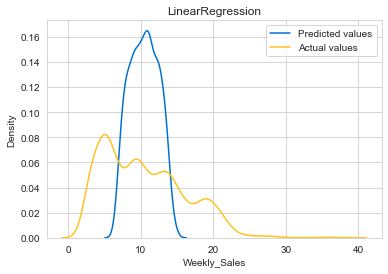

In [46]:
evaluate_model(y_test,lr_y_pred,'LinearRegression')

#### <u> Comment</u>:  
Linear results are quite low => it is possible that the model is not complex enough.

#### 4.2.2. RandomForestRegressor.

In [47]:
import copy
df_copy = copy.deepcopy(df)
df_copy = df_copy[['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day']]

In [48]:
x = df_copy.drop('Weekly_Sales', axis=1)
y = df_copy['Weekly_Sales']

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0, stratify = x['Holiday_Flag'])

In [50]:
# Perform features standardization.
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [51]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
rf_y_pred = rf.predict(x_test)

metrics_scoring_table(y_test,rf_y_pred,'RandomForestRegressor')

,Model,R2_score,RMSE
0,RandomForestRegressor,0.972658,0.911724


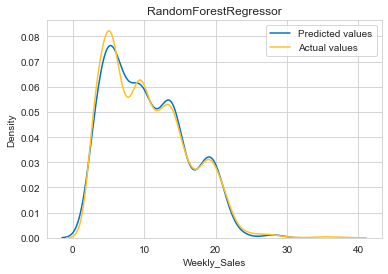

In [52]:
evaluate_model(y_test,rf_y_pred,'RandomForestRegressor')

#### 4.2.3. DecisionTreeRegressor.

In [53]:
DTR = DecisionTreeRegressor()

DTR.fit(x_train,y_train)
DTR_y_pred = DTR.predict(x_test)

metrics_scoring_table(y_test,DTR_y_pred,'DecisionTreeRegressor')

,Model,R2_score,RMSE
0,DecisionTreeRegressor,0.95513,1.167941


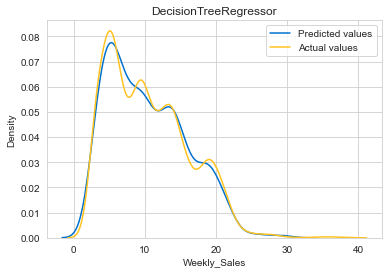

In [54]:
evaluate_model(y_test,DTR_y_pred,'DecisionTreeRegressor')

#### 4.2.4. XGBRegressor.

In [55]:
XGB = XGBRegressor()

XGB.fit(x_train,y_train)
XGB_y_pred = XGB.predict(x_test)

metrics_scoring_table(y_test,XGB_y_pred,'XGBRegressor')

,Model,R2_score,RMSE
0,XGBRegressor,0.985755,0.658076


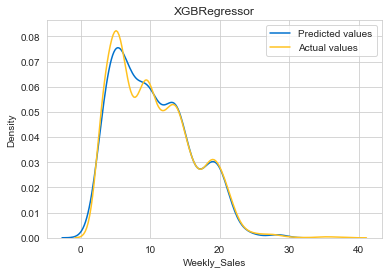

In [56]:
evaluate_model(y_test,XGB_y_pred,'XGBRegressor')

#### 4.2.5. LGBMRegressor.

In [57]:
LGBM = LGBMRegressor()

LGBM.fit(x_train,y_train)
LGBM_y_pred = LGBM.predict(x_test)

metrics_scoring_table(y_test,LGBM_y_pred,'LGBMRegressor')

,Model,R2_score,RMSE
0,LGBMRegressor,0.981647,0.746956


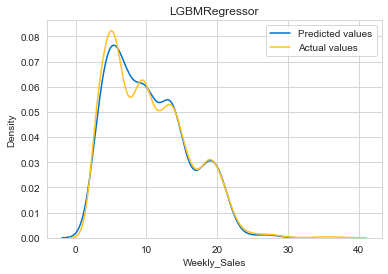

In [58]:
evaluate_model(y_test,LGBM_y_pred,'LGBMRegressor')

### 4.3. Model Evaluation Summary

In [59]:
score_1 = metrics_scoring_table(y_test,lr_y_pred,'LinearRegression')
score_2 = metrics_scoring_table(y_test,rf_y_pred,'RandomForestRegressor')
score_3 = metrics_scoring_table(y_test,DTR_y_pred,'DecisionTreeRegressor')
score_4 = metrics_scoring_table(y_test,XGB_y_pred,'XGBRegressor')
score_5 = metrics_scoring_table(y_test,LGBM_y_pred,'LGBMRegressor')
score = pd.concat([score_1,score_2,score_3,score_4,score_5], axis=0)
score

,Model,R2_score,RMSE
0,LinearRegression,0.117004,5.181131
0,RandomForestRegressor,0.972658,0.911724
0,DecisionTreeRegressor,0.955130,1.167941
0,XGBRegressor,0.985755,0.658076
0,LGBMRegressor,0.981647,0.746956


#### <u> Comment</u>:  
- Models: <b><u> XGBRegressor, RandomForestRegressor, LGBMRegressor</b></u> have quite high R-Squared values (almost 1) and lowest values of RMSE.
- => Use 3 above-mentioned models for Tuning.

[0.67004616 0.00345637 0.01232612 0.00886838 0.15475538 0.09978586
 0.02077152 0.028925   0.00106521]


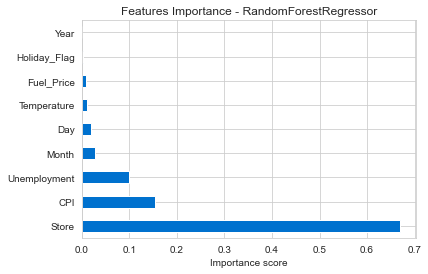

In [60]:
X = df[['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Day', 'Month', 'Year']]
y = df['Weekly_Sales']    
model_im = RandomForestRegressor(n_estimators=100)
model_im.fit(X,y)
print(model_im.feature_importances_) 
feat_importances = pd.Series(model_im.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel('Importance score')
plt.title('Features Importance - RandomForestRegressor')
plt.show()

#### <u> Comment</u>:  
- Features: <b> Store, CPI, Unemployment </b> have a quite important role in Model development.

### 4.4. Model Tuning.

#### 4.3.1. RandomForestReg.

In [61]:
parameters_RF =   {'n_estimators': [100,150]
                  ,'max_depth': [None]
                  ,'max_features': [0.75]
                  ,"n_jobs":[-1]
                  }
model_RF,best_param_RF = model(RandomForestRegressor(),parameters_RF,x_train,y_train, 4)
best_param_RF

{'max_depth': None, 'max_features': 0.75, 'n_estimators': 150, 'n_jobs': -1}

In [62]:
rf_y_pred_tuned = model_RF.predict(x_test)

Result_RF = metrics_scoring_table(y_test,rf_y_pred,'RandomForestRegressor')
Result_RF = Result_RF.append(metrics_scoring_table(y_test,rf_y_pred_tuned,'RandomForestRegressor_Tuning'))
Result_RF

,Model,R2_score,RMSE
0,RandomForestRegressor,0.972658,0.911724
0,RandomForestRegressor_Tuning,0.974028,0.888579


#### 4.3.2. LGBMRegressor.

In [63]:
def mod_LGBM(x_train,y_train,x_test,y_test,cv=4):
    from lightgbm import LGBMRegressor,log_evaluation
    from lightgbm import early_stopping
    parameters = {
    "learning_rate": [0.5,0.6,0.7],
    "subsample":[0.75],
    "n_estimators": [150,300,500],
    "max_depth": [15],
    "colsample_bytree":[0.7,0.9],  
    "reg_lambda":[0,1],
    "reg_alpha": [0,1],
       "verbose":[0]
#      "scale_pos_weight": [15],
    #"n_jobs":[-1]
    }    
    eval_set = [(x_train,y_train),(x_test,y_test)]
        
    regressor=LGBMRegressor (objective='regression', seed=0,verbose_eval=False)

    LGBM_grid = GridSearchCV(regressor,parameters,cv=cv)
    LGBM_grid.fit(x_train,y_train
                  ,eval_set=eval_set
                  ,eval_metric=['rmse']
                  ,callbacks=[
                  early_stopping(stopping_rounds=5,first_metric_only=False)
                  ]
                  
                 )

    LGBM_grid.best_params_
    
   
    return LGBM_grid,LGBM_grid.best_params_

In [64]:
%%capture
model_LGBM,best_param_LGBM =mod_LGBM(x_train,y_train,x_test,y_test)
best_param_LGBM

In [65]:
LGBM_y_pred_tuned = model_LGBM.predict(x_test)

Result_LGBM = metrics_scoring_table(y_test,LGBM_y_pred,'LGBMRegressor')
Result_LGBM = Result_LGBM.append(metrics_scoring_table(y_test,LGBM_y_pred_tuned,'LGBMRegressor_Tuning'))
Result_LGBM

,Model,R2_score,RMSE
0,LGBMRegressor,0.981647,0.746956
0,LGBMRegressor_Tuning,0.979600,0.787522


#### 4.3.3. XGBoosting.

In [66]:
parameters_XGB = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10]
       }

model_XGB,best_param_XGB = model(XGBRegressor(),parameters_XGB,x_train,y_train, 4)

best_param_XGB

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 800}

In [67]:
XGB_y_pred_tuned = model_XGB.predict(x_test)

Result_XGB = metrics_scoring_table(y_test,XGB_y_pred,'XGBRegressor')
Result_XGB = Result_XGB.append(metrics_scoring_table(y_test,XGB_y_pred_tuned,'XGBRegressor_Tuning'))

Result_XGB

,Model,R2_score,RMSE
0,XGBRegressor,0.985755,0.658076
0,XGBRegressor_Tuning,0.987871,0.607243


#### 4.3.4. Results.

In [68]:
Result_all = pd.concat([ Result_RF, Result_XGB, Result_LGBM],axis = 0)
Result_all

,Model,R2_score,RMSE
0,RandomForestRegressor,0.972658,0.911724
0,RandomForestRegressor_Tuning,0.974028,0.888579
0,XGBRegressor,0.985755,0.658076
0,XGBRegressor_Tuning,0.987871,0.607243
0,LGBMRegressor,0.981647,0.746956
0,LGBMRegressor_Tuning,0.979600,0.787522


## 5. Conclusion.

- Model <b>XGBoosting</b> gives the best results.

## 6. Recommendation and Benefits.

- Sales are very high in November and December and decrease in January. Therefore, supermarkets should hire more seasonal staff in November and December and can encourage permanent employees to take leave after January instead of November, December.
- Based on important features, stores can improve the business situation by using this report to make decisions about staffing, expansion or reduction.<br>
*Stores that sell less should find ways to increase their size and capacity to accommodate more items and consumer products.* <br>
*Special coupons can be distributed during low sales and during the holiday season with proper marketing to attract more customers.*

# ---------------------------------------------------------------------------------

# An Extra part - Time Series method for a single Store

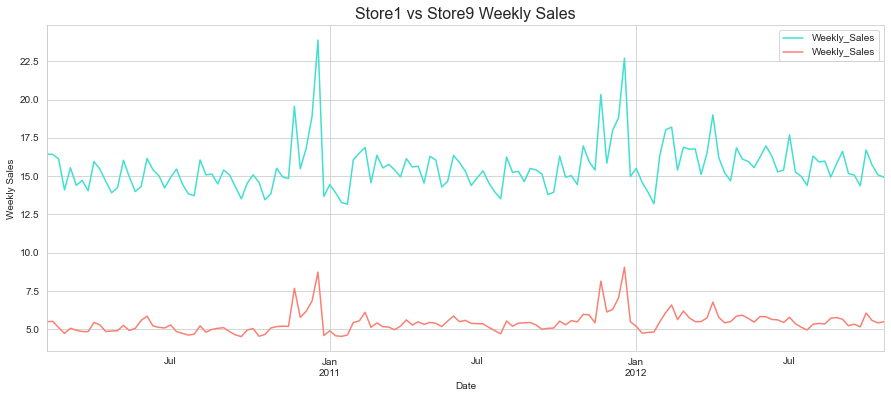

In [69]:
store9 = df[df['Store'] == 9]
sales9 = pd.DataFrame(store9['Weekly_Sales'].groupby(store9['Date']).sum())

store1 = df[df['Store'] == 1]
sales1 = pd.DataFrame(store1['Weekly_Sales'].groupby(store1['Date']).sum())

y1=sales1.Weekly_Sales
y2=sales9.Weekly_Sales
y1.plot(figsize=(15, 6), legend=True, color = 'turquoise')
y2.plot(figsize=(15, 6), legend=True, color = 'salmon')
plt.ylabel('Weekly Sales')
plt.title('Store1 vs Store9 Weekly Sales', fontsize = '16')
plt.show()

<Figure size 432x288 with 0 Axes>

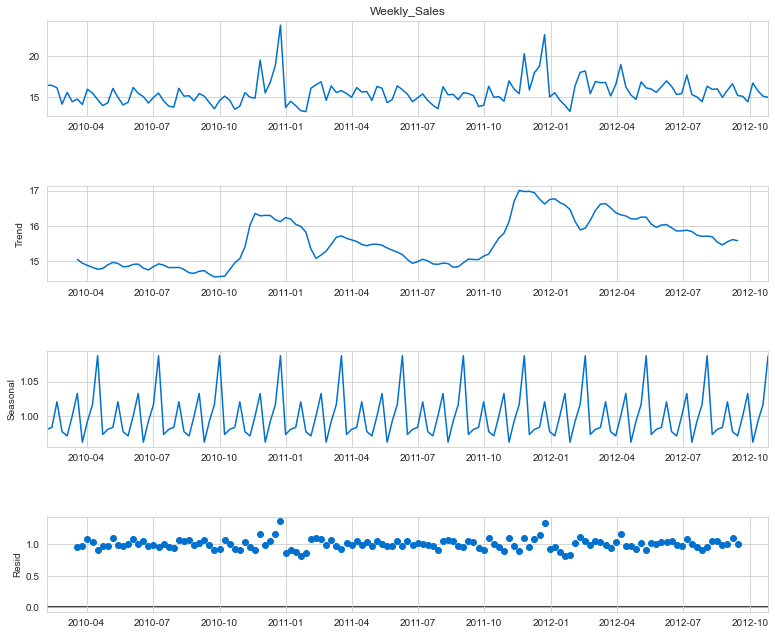

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(sales1.Weekly_Sales, period=12,model="multiplicative")  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 10)
plt.show()

#### <u> Comment</u>: 
The trends of the two stores are quite similar with peak points falling in the last months of the year - when there are the most holidays; dataset has high seasonality

### TimeSeries with Store No.1 - ARIMA:

In [71]:
import copy
df_ts = copy.deepcopy(df)
df_ts

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day,Super_Bowl,Labour_Day,Thanksgiving,Christmas
0,1,2010-02-05,16.436909,0,42.31,2.572,211.096358,8.106,2010,2,5,5,0,0,0,0
1,1,2010-02-12,16.419574,1,38.51,2.548,211.242170,8.106,2010,2,6,12,1,0,0,0
2,1,2010-02-19,16.119682,0,39.93,2.514,211.289143,8.106,2010,2,7,19,0,0,0,0
3,1,2010-02-26,14.097276,0,46.63,2.561,211.319643,8.106,2010,2,8,26,0,0,0,0
4,1,2010-03-05,15.548067,0,46.50,2.625,211.350143,8.106,2010,3,9,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,7.131739,0,64.88,3.997,192.013558,8.684,2012,9,39,28,0,0,0,0
6431,45,2012-10-05,7.334551,0,64.89,3.985,192.170412,8.667,2012,10,40,5,0,0,0,0
6432,45,2012-10-12,7.344644,0,54.47,4.000,192.327265,8.667,2012,10,41,12,0,0,0,0
6433,45,2012-10-19,7.181255,0,56.47,3.969,192.330854,8.667,2012,10,42,19,0,0,0,0


In [72]:
cond = (df_ts['Store']==1)
df_ts = df_ts.loc[cond]
df_ts = df_ts.drop(['Store', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day', 'Super_Bowl','Labour_Day','Thanksgiving','Christmas'], axis = 1)

In [73]:
#Set the index of the Month 
df_ts.set_index('Date',inplace=True)
df_ts

,Weekly_Sales
Date,
2010-02-05,16.436909
2010-02-12,16.419574
2010-02-19,16.119682
2010-02-26,14.097276
2010-03-05,15.548067
...,...
2012-09-28,14.370593
2012-10-05,16.707860
2012-10-12,15.730728


In [74]:
#Testing for stationarity
from pmdarima.arima import ADFTest,auto_arima
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df_ts)

(0.01, False)

In [75]:
train = df_ts[:115]
test = df_ts[-28:]
# train 80% first, test 20% rest

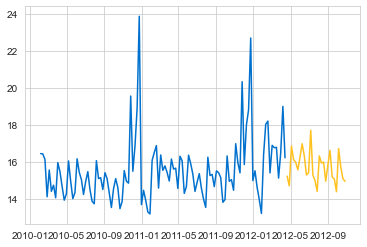

In [76]:
plt.plot(train)
plt.plot(test)

In [77]:
arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=501.803, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=458.366, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=487.975, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=453.235, Time=0.16 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=438.020, Time=0.44 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=437.274, Time=0.88 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=439.067, Time=1.70 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.50 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=435.762, Time=1.11 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=5.50 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=444.349, Time=

In [78]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  115
Model:             SARIMAX(2, 1, 0)x(3, 1, [1], 12)   Log Likelihood                -209.533
Date:                              Thu, 24 Nov 2022   AIC                            433.065
Time:                                      18:42:15   BIC                            451.440
Sample:                                  02-05-2010   HQIC                           440.506
                                       - 04-13-2012                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4141      0.073     -5.669      0.000      -0.557      -0.271
ar.L2         -0.2218      0.085     -2.615      0.009      -0.388      -0.056
ar.S.L12      -0.2304      0.244     -0.945      0.345      -0.708       0.248
ar.S.L24      -0.2139      0.206     -1.039      0.299      -0.618       0.190
ar.S.L36      -0.2621      0.150     -1.747      0.081      -0.556       0.032
ma.S.L12      -0.8272      0.440     -1.881      0.060      -1.689       0.035
sigma2         2.7494      0.827      3.325      0.001       1.129       4.370
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                28.00
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.03   Skew:                            -0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 28),index=test.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
Date,
2012-04-20,15.459039
2012-04-27,16.451221
2012-05-04,16.590944
2012-05-11,17.729584
2012-05-18,15.483610
2012-05-25,15.114835
2012-06-01,15.427443
2012-06-08,15.498688
2012-06-15,15.207388


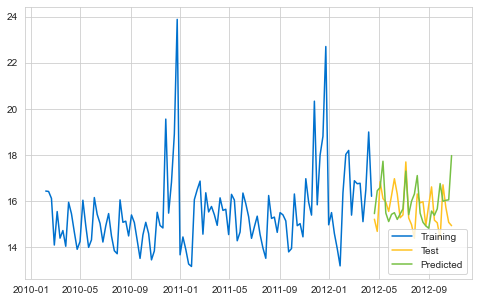

In [80]:
plt.figure(figsize=(8,5))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'lower right')
plt.show()

In [81]:
metrics_scoring_table(df_ts[-28:].to_numpy(),prediction.to_numpy(),'Time Series with Store No.1 - ARIMA')

,Model,R2_score,RMSE
0,Time Series with Store No.1 - ARIMA,-0.980602,1.133148
